In [2]:

import numpy as np
import astropy.units as u
from astropy.io import fits

import scoobpsf
import scoobpsf.ad_scoob as ad_scoob
import scoobpsf.utils as utils
from scoobpsf.math_module import xp, _scipy, ensure_np_array
from scoobpsf.imshows import imshow1, imshow2, imshow3

from importlib import reload

import matplotlib.pyplot as plt
from matplotlib.patches import Circle

from scipy.optimize import minimize

npix = 500
wavelength = 650e-9*u.m
pupil_diam = 9.4*u.mm

15.957446808510637
952


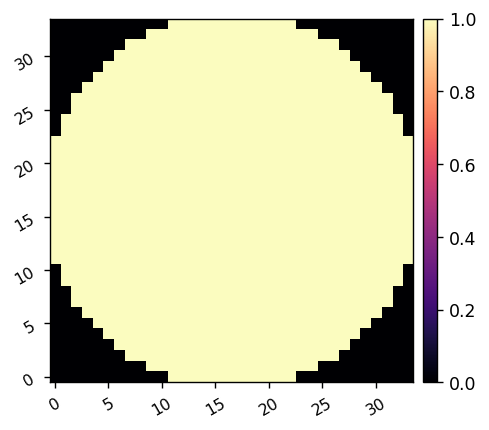

574


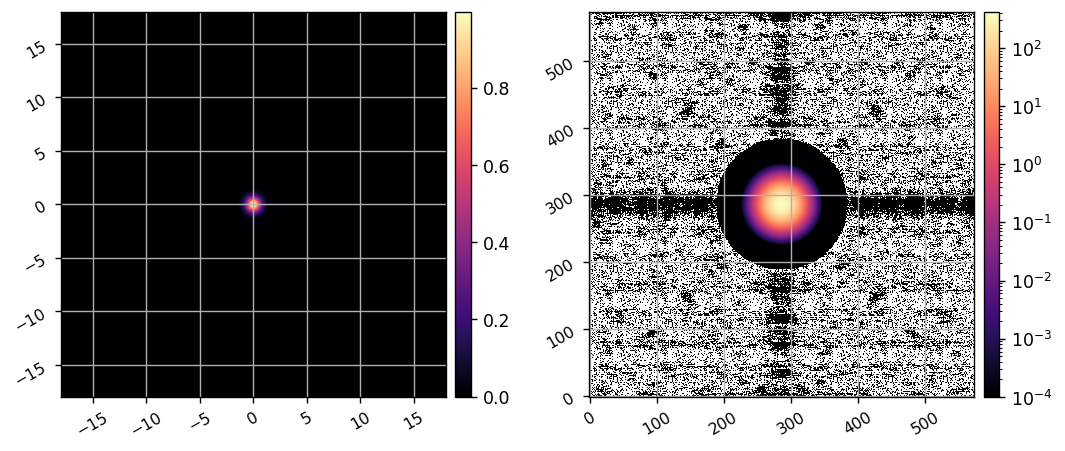

In [3]:
Nact = 34
act_spacing = 0.3*u.mm
inf_sampling = (npix/pupil_diam * act_spacing).value
print(inf_sampling)

dm_mask = xp.ones((Nact,Nact), dtype=bool)
xx = (xp.linspace(-Nact//2, Nact//2 - 1, Nact) + 1/2)
x,y = xp.meshgrid(xx,xx)
r = xp.sqrt(x**2 + y**2)
dm_mask[r>(Nact/2 + 1/2)] = 0
Nacts = int(xp.sum(dm_mask))
print(Nacts)
imshow1(dm_mask)

reload(ad_scoob)
inf_fun = ad_scoob.make_gaussian_inf_fun(act_spacing=act_spacing, sampling=inf_sampling, 
                                         Nacts_per_inf=Nact + 2, # number of influence functions across the grid
                                         coupling=0.15,)

Nsurf = inf_fun.shape[0]
print(Nsurf)

# fourier_inf_fun = xp.fft.fft2(inf_fun,)
# imshow2(inf_fun, xp.abs(xp.fft.fftshift(fourier_inf_fun)), pxscl1=1/inf_sampling, grid=True, lognorm2=True, vmin2=1e-4)

inf_fun_fft = xp.fft.fftshift(xp.fft.fft2(xp.fft.ifftshift(inf_fun,)))
# inf_fun_fft *= xp.sum(inf_fun)/xp.sum(xp.abs(inf_fun_fft))
imshow2(inf_fun, xp.abs(inf_fun_fft), pxscl1=1/inf_sampling, grid=True, lognorm2=True, vmin2=1e-4)

# DM command coordinates
xc = inf_sampling*(xp.linspace(-Nact//2, Nact//2-1, Nact) + 1/2)
yc = inf_sampling*(xp.linspace(-Nact//2, Nact//2-1, Nact) + 1/2)

# Influence function frequncy sampling
fx = xp.fft.fftshift(xp.fft.fftfreq(Nsurf))
fy = xp.fft.fftshift(xp.fft.fftfreq(Nsurf))

# forward DM model MFT matrices
Mx = xp.exp(-1j*2*np.pi*xp.outer(fx,xc))
My = xp.exp(-1j*2*np.pi*xp.outer(yc,fy))

Mx_back = xp.exp(1j*2*np.pi*xp.outer(xc,fx))
My_back = xp.exp(1j*2*np.pi*xp.outer(fy,yc))

In [3]:
xp.sum(inf_fun), xp.sum(xp.abs(inf_fun_fft)), 

(array(421.67891383), array(329476.))

Oversampling > 2x suggested for reliable results in Fresnel propagation.


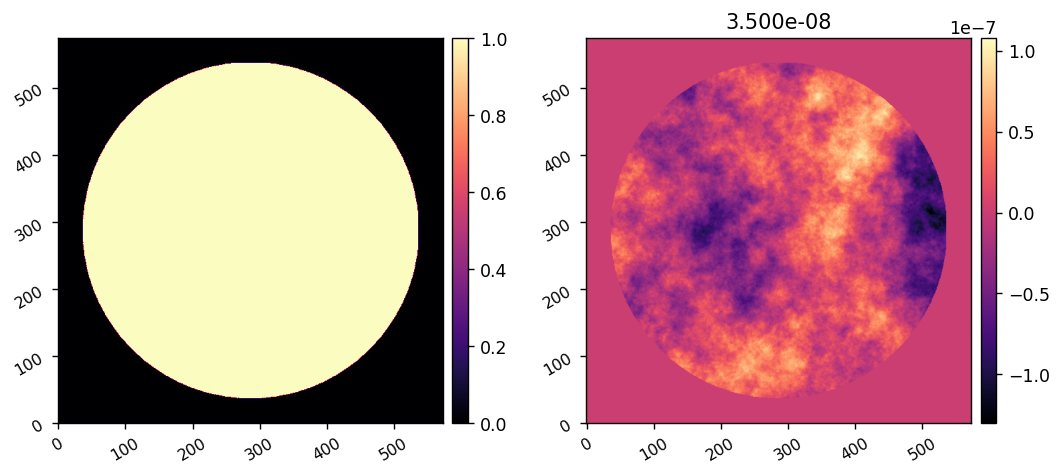

In [4]:
reload(utils)
WFE, mask = utils.generate_wfe(diam=pupil_diam,
                                npix=npix, oversample=1,
                                wavelength=wavelength,
                                opd_index=3, amp_index=3,
                                opd_rms=35*u.nm, amp_rms=0.05,
                                # opd_seed=12, amp_seed=1234,
                                remove_modes=12)

mask = utils.pad_or_crop(mask, Nsurf)
WFE = utils.pad_or_crop(WFE, Nsurf)

wfe_opd = xp.angle(WFE)*wavelength.to_value(u.m)/2/np.pi
rms_opd = xp.sqrt(xp.mean(xp.square(wfe_opd[mask])))
imshow2(mask, wfe_opd,  '', f'{rms_opd:.3e}')

In [9]:
inf_matrix = xp.zeros((Nsurf**2, Nacts))
count = 0
for i in range(Nact):
    for j in range(Nact):
        if dm_mask[i,j]:
            x_shift = (j-Nact/2 + 1/2)*inf_sampling
            y_shift = (i-Nact/2 + 1/2)*inf_sampling
            inf_matrix[:,count] = _scipy.ndimage.shift(inf_fun, (y_shift,x_shift)).ravel()
            count += 1


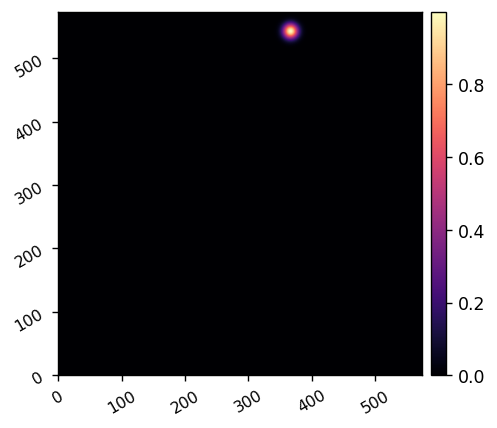

In [23]:
i = 951
imshow1(inf_matrix[:,i].reshape(Nsurf,Nsurf))

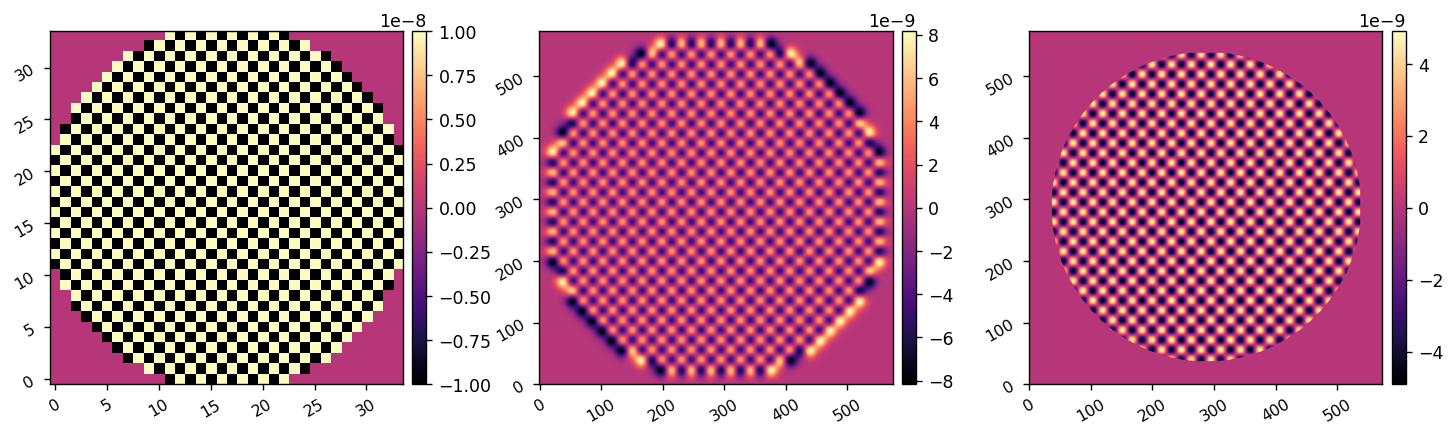

In [10]:
def forward_dm(actuators):
    # command = xp.zeros((Nact,Nact))
    # command[dm_mask] = actuators
    # mft_command = Mx@command@My
    # fourier_surf = inf_fun_fft * mft_command
    # # surf = 2 * xp.fft.ifft2(fourier_surf,).real
    # surf = xp.fft.ifftshift(xp.fft.ifft2(xp.fft.fftshift(fourier_surf,))).real

    surf = inf_matrix.dot(xp.array(actuators)).reshape(Nsurf,Nsurf)
    return surf

waffle_command = 10e-9 * xp.ones((Nact,Nact))
waffle_command[1::2, ::2] *= -1
waffle_command[::2, 1::2] *= -1
waffle_command *= dm_mask
waffle_surf = forward_dm(waffle_command[dm_mask])
imshow3(waffle_command, waffle_surf, waffle_surf*mask)

# command = 1e-8 * dm_mask * xp.random.randn(Nact**2).reshape(Nact,Nact)
# surf = forward_dm(command[dm_mask])
# imshow3(command, surf, surf*mask)

1.0
(952,)


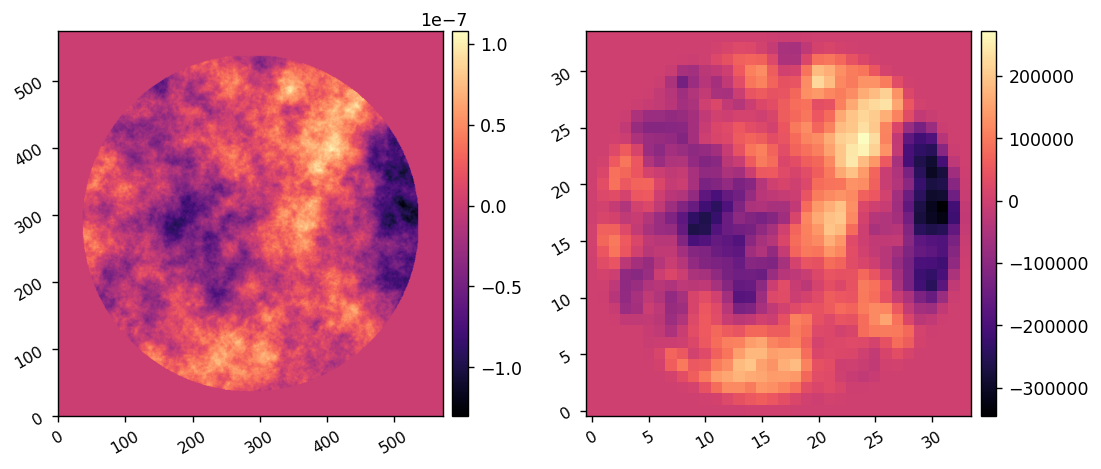

In [12]:
def val_and_grad(actuators):
    wfe_l2norm = wfe_opd[mask].dot(wfe_opd[mask])

    actuators = xp.array(actuators)
    s_dm = forward_dm(actuators)
    total_wfe =  wfe_opd + s_dm
    J = total_wfe[mask].dot(total_wfe[mask]) / wfe_l2norm
    print(J)

    masked_total = mask * total_wfe
    dJ_dwfe = 2 * (masked_total) / wfe_l2norm
    # x2_bar = xp.fft.fftshift(xp.fft.fft2(xp.fft.ifftshift(dJ_dwfe.real)))
    # x1_bar = inf_fun_fft.conjugate() * x2_bar
    # dJ_dA = Mx_back@x1_bar@My_back / xp.sum(xp.abs(Mx_back))
    # dJ_dA = dJ_dA[dm_mask].real

    dJ_dA = inf_matrix.T.dot(dJ_dwfe.flatten())

    # print(dJ_dA.dot(dJ_dA))

    return ensure_np_array(J), ensure_np_array(dJ_dA)

actuators = xp.zeros(Nacts)
J0, dJ_dA = val_and_grad(actuators)
print(dJ_dA.shape)

dm_grad = xp.zeros((Nact,Nact), dtype=dJ_dA.dtype)
dm_grad[dm_mask] = dJ_dA
imshow2(wfe_opd, dm_grad)

In [22]:
print(xp.max(xp.abs(dm_grad)))

0.38303872264556954


### use the matrix multiplication surface model for the DM just to test the forward and adjoint models
### implement DM model with Jax and then have minimize operate with the val_and_grad function from Jax
### implement unit testable forward and adjoint models

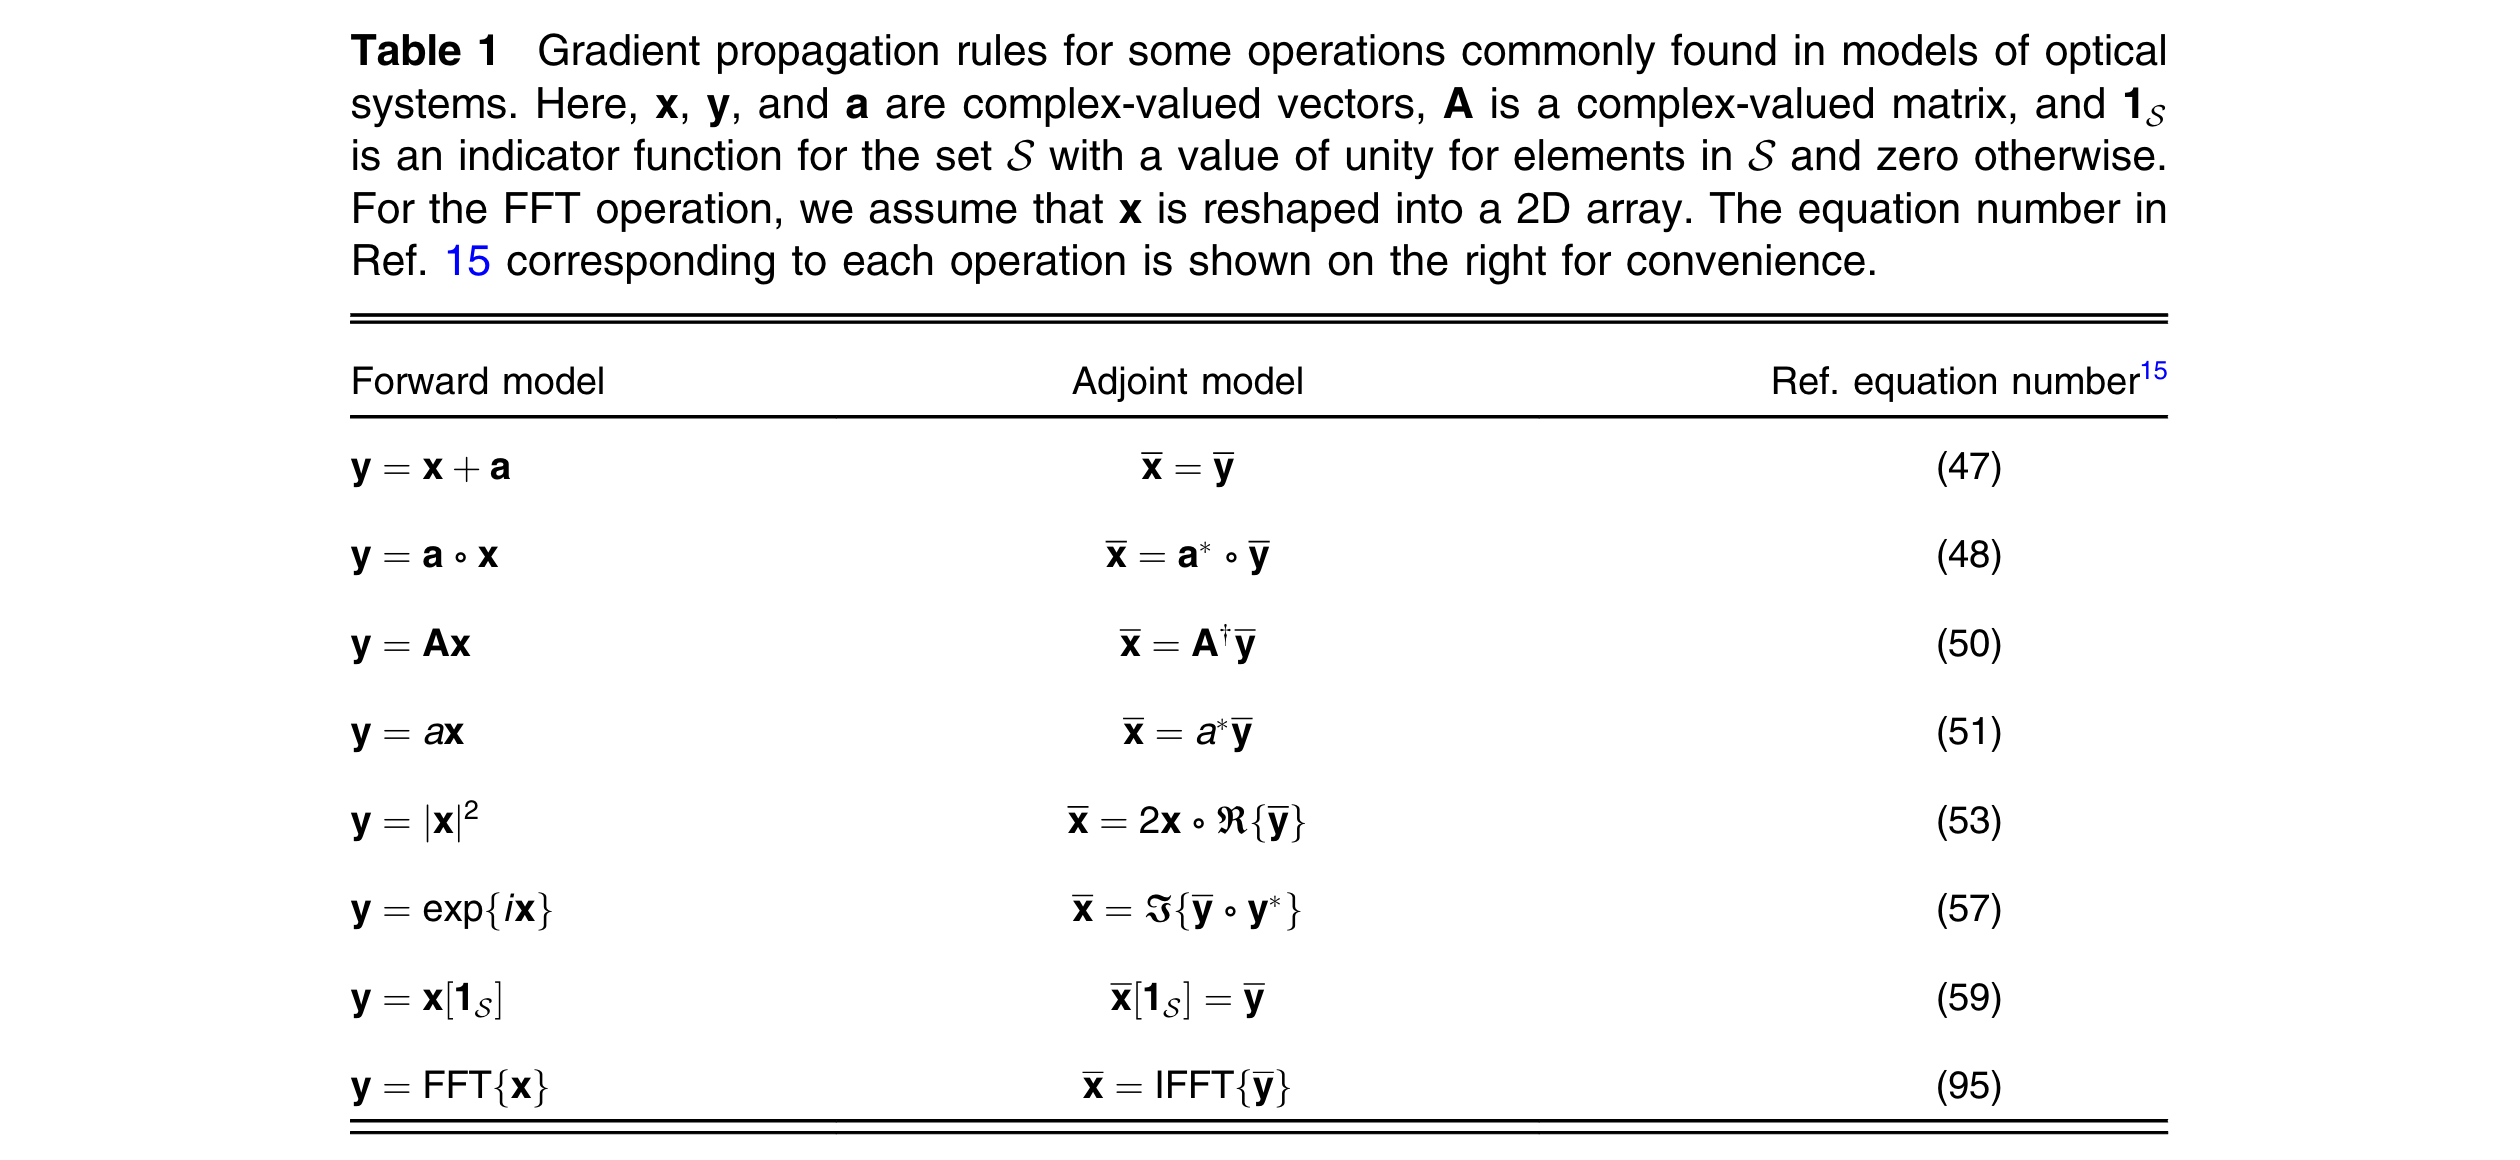

In [13]:
lbfgs_tol = 1e-3
options = {
    'disp':True, 
    'maxiter':30,
    'maxls':100, # default is 20
    'ftol':1e-6, 
    'gtol':1e-6,
}

del_acts0 = np.zeros(Nacts)
# del_acts0 = np.random.randn(Nacts) * 1e-9
result = minimize(val_and_grad, 
                  jac=True, 
                  x0=del_acts0, 
                  method='L-BFGS-B',
                #   method='CG',
                  tol=lbfgs_tol,
                  options=options,
                  )

dm_command = result['x']

1.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          952     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00000D+00    |proj g|=  3.45973D+05
2591044413195.7305
0.09486779644340866

At iterate    1    f=  9.48678D-02    |proj g|=  5.87075D+04
0.06798716919591515

At iterate    2    f=  6.79872D-02    |proj g|=  3.23455D+04
0.052972029870652915

At iterate    3    f=  5.29720D-02    |proj g|=  1.33587D+04
0.04936210050911167

At iterate    4    f=  4.93621D-02    |proj g|=  9.10840D+03
0.04780505906222657

At iterate    5    f=  4.78051D-02    |proj g|=  9.00241D+03
0.047099001602367095

At iterate    6    f=  4.70990D-02    |proj g|=  4.64535D+03
0.04672425772702977

At iterate    7    f=  4.67243D-02    |proj g|=  3.25234D+03
0.04640175152770208

At iterate    8    f=  4.64018D-02    |proj g|=  2.83138D+03
0.04639564454632419
0.04626234132260808

At iterate    9    f=  4.62623D-02    |proj g|=  

 This problem is unconstrained.


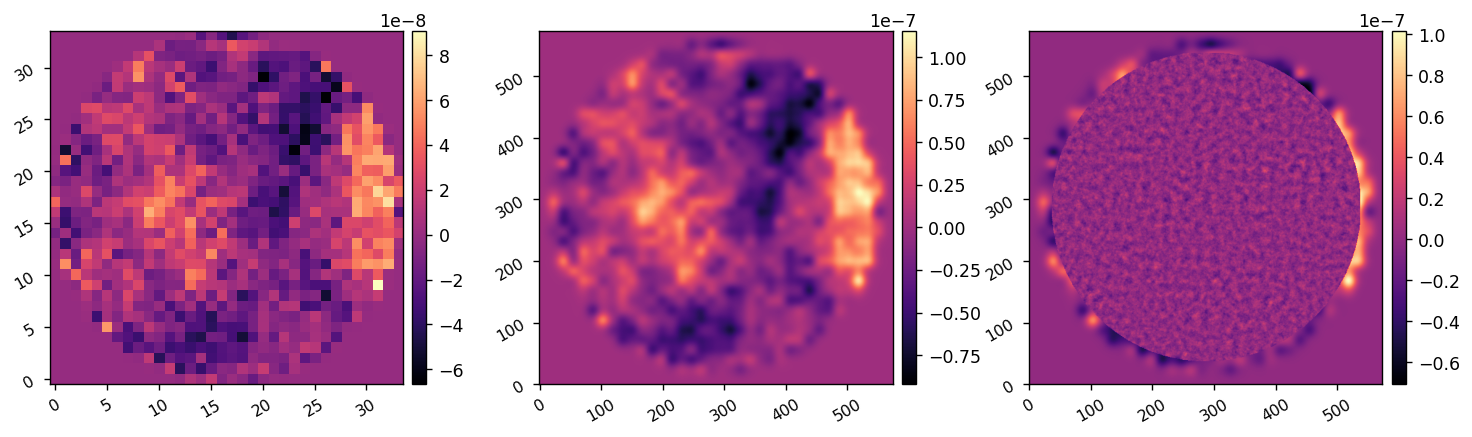

In [14]:

min_command = xp.zeros((Nact,Nact))
min_command[dm_mask] = result.x
surf = forward_dm(result.x)

imshow3(min_command, surf, wfe_opd+surf)

1.0
0.6742847639564231
0 0.3257152360435769
0.46525267403800175
1 0.31000565501718863
0.33029421497719347
2 0.2900756225417952
0.24252229731186298
3 0.26573858604030065
0.1849317087475877
4 0.23746512878450393
0.14673872916604053
5 0.20652477522757634
0.12108406317090184
6 0.174832275984273
0.10358920961287206
7 0.1444851873969326
0.09144771133326084
8 0.11720813707321225
0.08285206712532375
9 0.09399518131855887
0.07663158736603033
10 0.07507935498922669
0.07202302400170187
11 0.060139213119985234
0.06852491890573104
12 0.04856926162789515
0.06580484214009111
13 0.03969470973591238
0.06364011673423359
14 0.03289614161293881
0.06187979682442788
15 0.02766053866866631
0.06042017208613826
16 0.023588066108733846
0.05918890746524955
17 0.020378369977717824
0.05813471514747199
18 0.017810639914184787
0.05722058491811251
19 0.015724343484621567
0.05641931368421124
20 0.014003198937025067
0.055710528188413086
21 0.012562816693683164
0.05507868314411105
22 0.01134157339462179
0.05451170077971

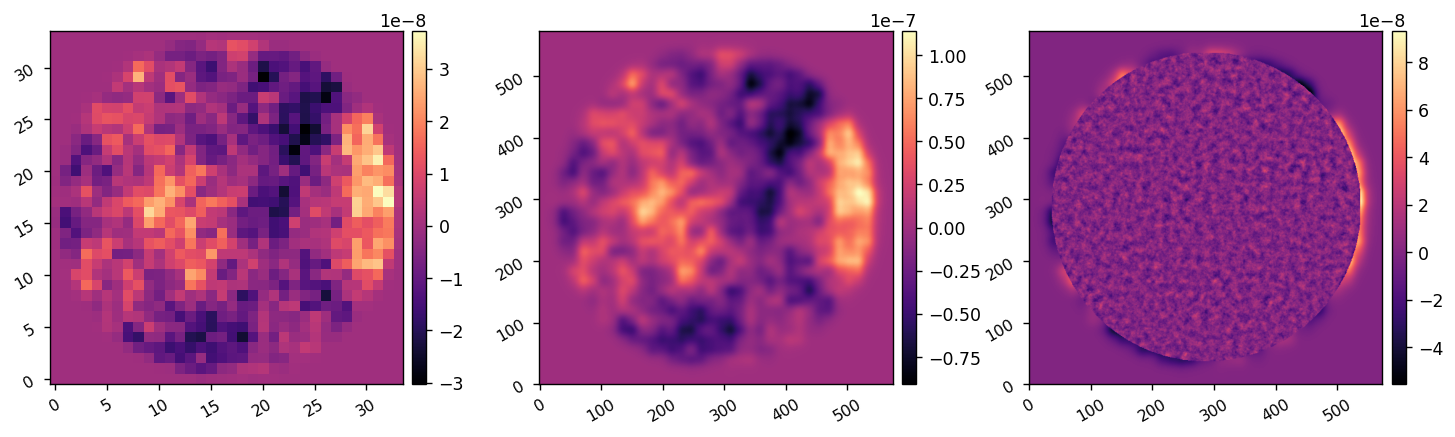

In [55]:
del_acts = np.zeros(Nacts)
J, dJ_dA = val_and_grad(del_acts)
J_prev = J
tol = 1e-3

for i in range(50):
    del_acts +=  dJ_dA
    J, dJ_dA = val_and_grad(del_acts)
    print(i, (J_prev-J)/J_prev)
    if (J_prev-J)/(J_prev)<tol:
        break
    J_prev = J

dm_command = xp.zeros((Nact,Nact), dtype=dJ_dA.dtype)
dm_command[dm_mask] = del_acts
s_dm = forward_dm(del_acts)

imshow3(dm_command, s_dm, wfe_opd+s_dm)


scipy.optimize.approx_fprime